In [1]:
import torch

import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers
from tensorflow.keras.utils import plot_model

In [2]:
directory_train = 'data\\Train'
directory_validation = 'data\\Val'
directory_testing = "data\\Test"

In [3]:
train_gen = ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip=True,
    vertical_flip=True
)

val_test_gen = ImageDataGenerator(
    rescale=1./255.
)

In [4]:
train_data = train_gen.flow_from_directory(
    directory=directory_train,
    color_mode="rgb",
    target_size=(331, 331),
    class_mode="categorical",
    batch_size=8,
    shuffle=True
)

val_data = val_test_gen.flow_from_directory(
    directory=directory_validation,
    color_mode="rgb",
    target_size=(331, 331),
    class_mode="categorical",
    batch_size=8,
    shuffle=False
)

test_data = val_test_gen.flow_from_directory(
    directory=directory_testing,
    color_mode="rgb",
    target_size=(331, 331),
    class_mode="categorical",
    batch_size=8,
    shuffle=False
)

Found 228 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [5]:
imgs, labels = next(train_data)
print("Images Shape: ", imgs.shape)
print("Labels: ", labels[:5])

Images Shape:  (8, 331, 331, 3)
Labels:  [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


Classes:  ['Covid', 'Normal']


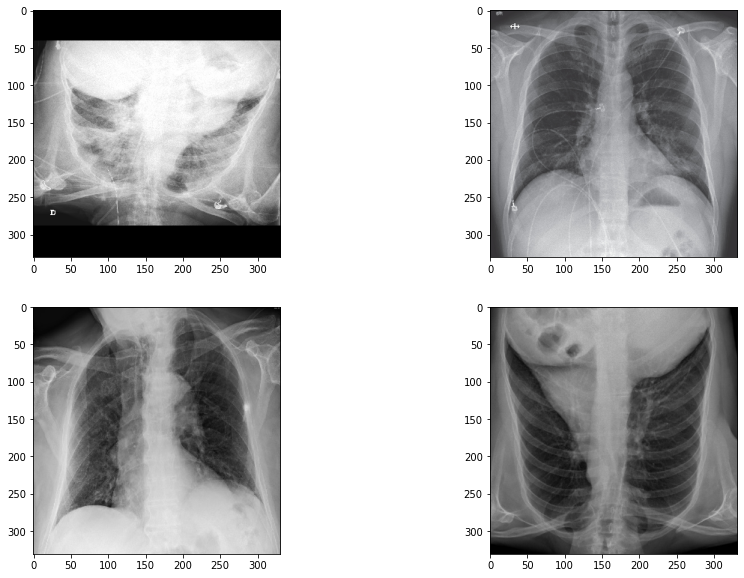

In [6]:
classes = train_data.class_indices
classes = list(classes.keys())
print("Classes: ", classes)

def plot_imgs(img, labels):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    img_index = 0
    for i in range(2):
        for j in range(2):
            ax[i][j].imshow(img[img_index])
            img_label = np.argmax(labels[img_index])
            img_index += 1

plot_imgs(imgs, labels)

In [8]:
def get_model():
    base_model = tf.keras.applications.VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=(331, 331, 3)
    )

    base_model.trainable = False


    x = layers.BatchNormalization(renorm=True)(base_model.output)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(120, activation="softmax")(x)
    output = layers.Dense(2, activation="softmax")(x)

    return models.Model(inputs=base_model.input, outputs=[output])

model = get_model()

model.summary()
plot_model(model, show_shapes=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 331, 331, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 331, 331, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 331, 331, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 165, 165, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 165, 165, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 165, 165, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 82, 82, 128)       0     

In [9]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
early = tf.keras.callbacks.EarlyStopping(patience=10, min_delta=0.001, restore_best_weights=True)

In [9]:
batch_size = 8
STEP_SIZE_TRAIN = train_data.n//train_data.batch_size
STEP_SIZE_VALID = val_data.n//val_data.batch_size

# fit model
history = model.fit(train_data,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_data,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=25,
                    callbacks=[early]
)

Epoch 1/25
28/28 [==============================] - 18s 414ms/step - loss: 0.6704 - categorical_accuracy: 0.5818 - val_loss: 0.6381 - val_categorical_accuracy: 0.6607
Epoch 2/25
28/28 [==============================] - 8s 268ms/step - loss: 0.5800 - categorical_accuracy: 0.8909 - val_loss: 0.5398 - val_categorical_accuracy: 0.9286
Epoch 3/25
28/28 [==============================] - 8s 272ms/step - loss: 0.5108 - categorical_accuracy: 0.9455 - val_loss: 0.5236 - val_categorical_accuracy: 0.8929
Epoch 4/25
28/28 [==============================] - 8s 273ms/step - loss: 0.4861 - categorical_accuracy: 0.9455 - val_loss: 0.4657 - val_categorical_accuracy: 0.9643
Epoch 5/25
28/28 [==============================] - 8s 276ms/step - loss: 0.4568 - categorical_accuracy: 0.9682 - val_loss: 0.4727 - val_categorical_accuracy: 0.9286
Epoch 6/25
28/28 [==============================] - 8s 275ms/step - loss: 0.4413 - categorical_accuracy: 0.9591 - val_loss: 0.4150 - val_categorical_accuracy: 0.9821
Epo

In [10]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: 0.9863636493682861 \nValidation Accuracy: 0.9821428656578064')

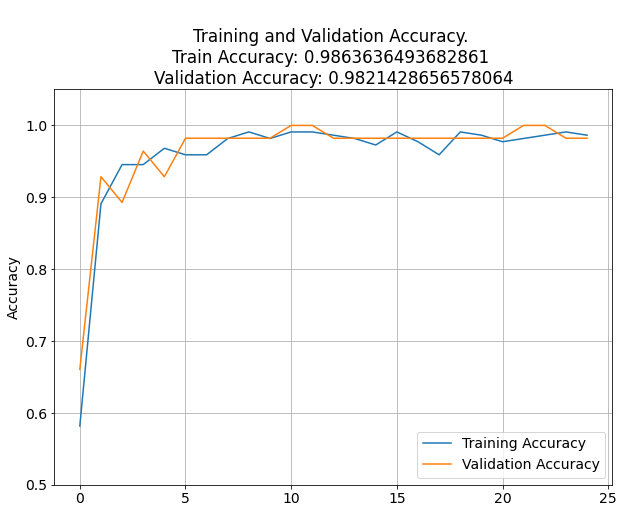

In [11]:
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.5,1.05])
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {(str(acc[-1]))} \nValidation Accuracy: {str(val_acc[-1])}')

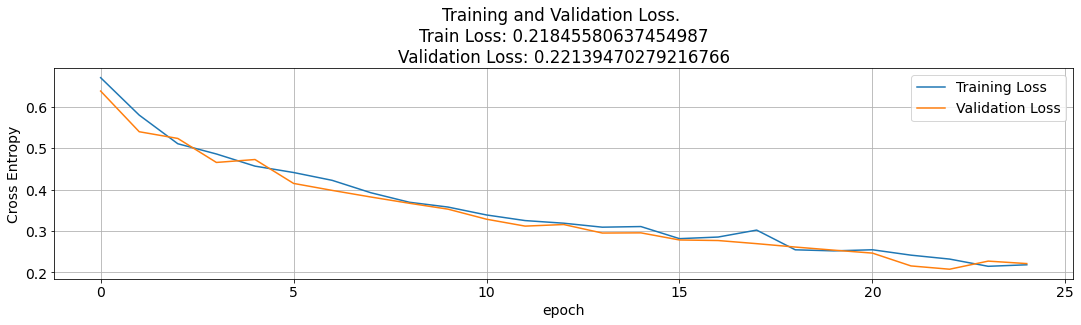

In [12]:
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [13]:
accuracy_score = model.evaluate(test_data)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))

print("Loss: ",accuracy_score[0])

8/8 [==============================] - 2s 245ms/step - loss: 0.2454 - categorical_accuracy: 0.9667
[0.2453615367412567, 0.9666666388511658]
Accuracy: 96.6667%
Loss:  0.2453615367412567


In [ ]:
model.save_weights("final2.h5")

In [11]:
model = get_model()
model.load_weights("final2.h5")
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [12]:
accuracy_score = model.evaluate(test_data)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))

print("Loss: ",accuracy_score[0])

8/8 [==============================] - 14s 718ms/step - loss: 0.2454 - categorical_accuracy: 0.9667
[0.2453615367412567, 0.9666666388511658]
Accuracy: 96.6667%
Loss:  0.2453615367412567
